<a href="https://colab.research.google.com/github/madhumitadange/ArtificialIntelligence/blob/master/CS230StrongGravitatialLensingPart2_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strong Gravitatial Lensing : Generate Original galaxy image using U-Net




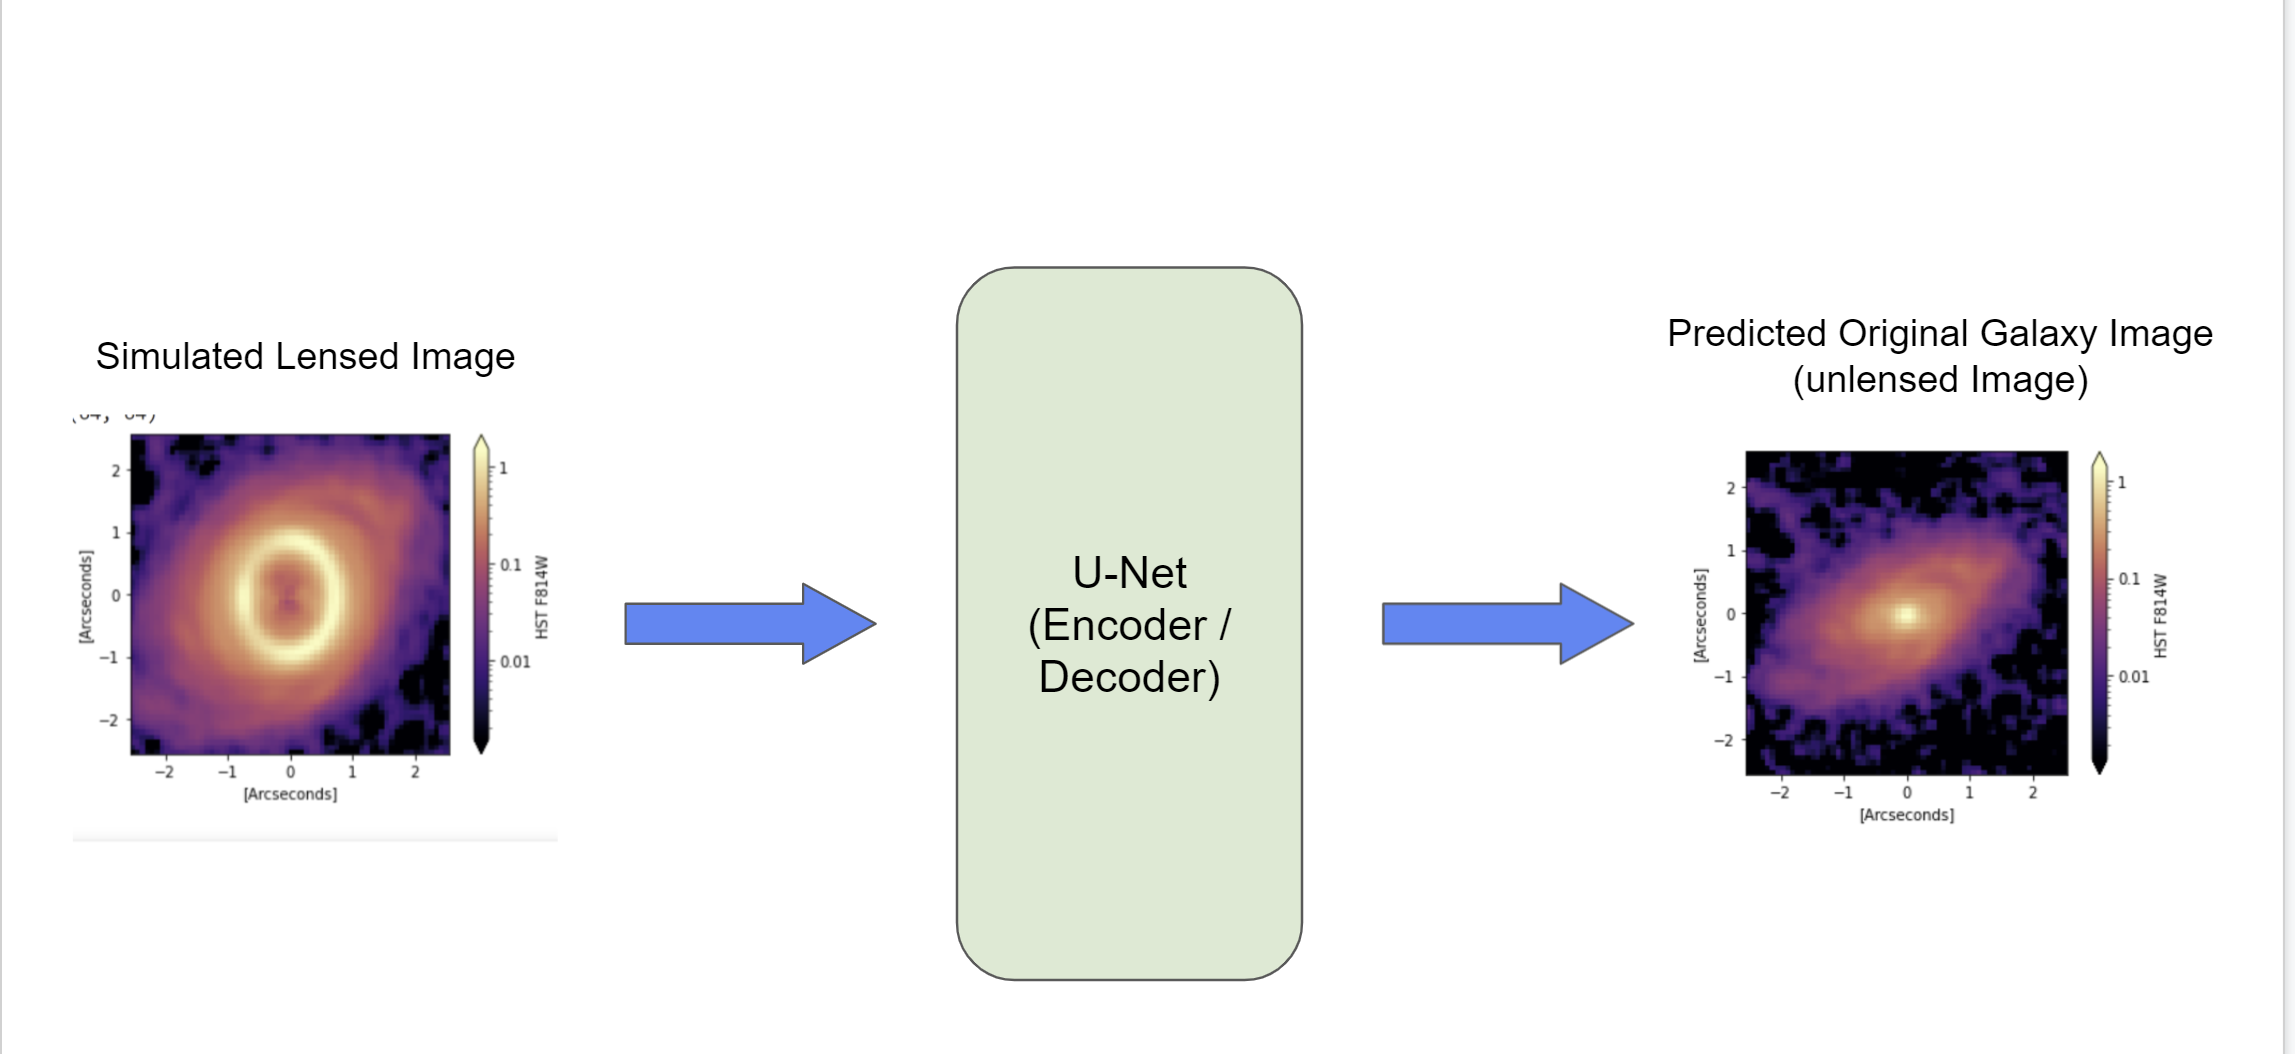

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
import random
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,BatchNormalization,Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


Read Data created by lenstronamy. Details about Preproccessing, data augmentation, test train, dev split etc in another Notebook 

In [3]:

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CS230/ProjectData.zip", 'r')
zip_ref.extractall("/CS230")
zip_ref.close()

#Helper Function to plot Lensed and Unlensed images
Ref: https://github.com/JelleAalbers/minilensmaker/tree/main/minilensmaker

In [4]:
def exporter():
    """Export utility modified from https://stackoverflow.com/a/41895194
    Returns export decorator, __all__ list
    """
    all_ = []

    def decorator(obj):
        all_.append(obj.__name__)
        return obj

    return decorator, all_


export, __all__ = exporter()
__all__.append("exporter")


@export
def image_grid(
    shape,
    pixel_width,
    x0=0,
    y0=0,
    edges=True,
):
    nx, ny = shape
    dx = nx * pixel_width
    dy = nx * pixel_width
    extra = 1 if edges else 0
    x = np.linspace(-dx / 2, dx / 2, nx + extra) + x0
    y = np.linspace(-dy / 2, dy / 2, ny + extra) + y0
    return x, y


@export
def plot_image(
    img,
    pixel_width,
    log_scale=True,
    label="HST F814W",
    colorbar=True,
    adjust_ax=True,
    vmin=None,
    vmax=None,
    **kwargs
):

    # Set reasonable defaults
    if vmax is None:
        vmax = img.max()
    if vmin is None:
        if log_scale:
            vmin = vmax * 1e-3
        else:
            vmin = img.min()
    kwargs.setdefault(
        "norm",
        matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        if log_scale
        else matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
    )
    kwargs.setdefault("cmap", "magma")

    # Plot image, note transposition
    plt.pcolormesh(
        *image_grid(img.shape, pixel_width), img.clip(vmin, None).T, **kwargs
    )
    if adjust_ax:
        plt.gca().set_aspect("equal")

    if colorbar:
        # Plot colorbar
        cbar = plt.colorbar(label=label, extend="both")
        cax = cbar.ax
        # Format colobar ticks as scalars (not 10^x)
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
        if len(cbar.get_ticks()) < 2:
            # If there are very few colorbar ticks, show minor ticks too
            cax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%g"))
            cax.tick_params(axis="y", labelsize=7, which="minor")

    plt.xlabel("[Arcseconds]")
    plt.ylabel("[Arcseconds]")


@export
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )#

In [5]:
!ls /CS230/ProjectData/test

Lensed	Unlensed


In [6]:
datafile = np.load("/CS230/ProjectData/train/Lensed/24178.npy")
np.amax(datafile)

1.5125014509087362

Visualized Gravitatinal lensing image

(64, 64)


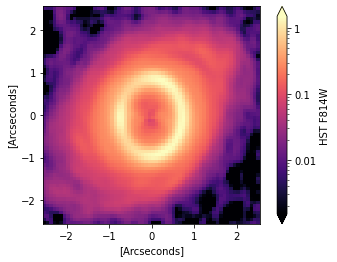

In [7]:
plot_image(datafile,pixel_width=0.08)
print(datafile.shape)

Visualization of Training data 

/CS230/ProjectData/train/Lensed/19477.npy
20211


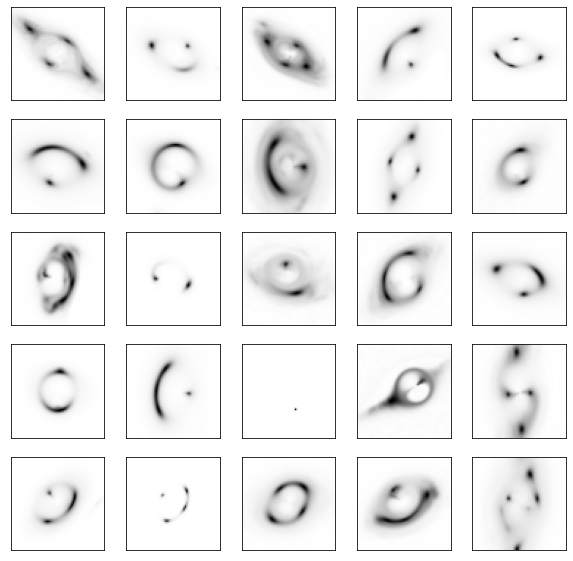

In [8]:
train_url = "/CS230//ProjectData/train/Lensed"

import pathlib

data = pathlib.Path('ProjectData.zip', train_url)
train_images = list(data.glob('*.npy'))

print(train_images[0])
print(len(train_images))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.load(train_images[i]) / 255
    plt.imshow(img, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    #plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Read Train Images and Train labels. Output layer is 8 continuous parameters 

In [9]:
trainPara = pd.read_csv("/CS230/ProjectData/trainParameters.csv")
#print(trainPara["source_rotation"].dtype)
#display(trainPara)
#print(trainPara.columns)
#trainFeatureName = trainPara["fileName"]
# train_images #/CS230/ProjectData/train/Lensed/52730_5.720406822933091.npy

trainLensedImage = []
trainUnlensedImage = []

for i in tqdm(range(trainPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/train/Unlensed/"+trainPara['fileName'][i].astype(str)+'.npy')
    trainLensedImage.append(img)
    trainUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/train/Lensed/"+trainPara['fileName'][i].astype(str))

xTrainLensed = np.array(trainLensedImage)
print(xTrainLensed.shape)
xTrainUnlensed = np.array(trainUnlensedImage)
print(xTrainUnlensed.shape)

#trainLabels = trainPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
##print(trainLabels.head())
#print(trainFeatureName.head())


100%|██████████| 20211/20211 [00:15<00:00, 1294.90it/s]


(20211, 64, 64)
(20211, 64, 64)


Read Dev Images and Dev labels.

In [10]:
devPara = pd.read_csv("/CS230/ProjectData/devParameters.csv")
devLensedImage = []
devUnlensedImage = []

for i in tqdm(range(devPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/dev/Unlensed/"+devPara['fileName'][i].astype(str)+'.npy')
    devLensedImage.append(img)
    devUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/dev/Lensed/"+devPara['fileName'][i].astype(str))

xDevLensed = np.array(devLensedImage)
print(xDevLensed.shape)
xDevUnlensed = np.array(devUnlensedImage)
print(xDevUnlensed.shape)

#devLabels = devPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
#print(devLabels.head())


100%|██████████| 1977/1977 [00:01<00:00, 1190.97it/s]


(1977, 64, 64)
(1977, 64, 64)


Read Test Images and Test labels.

In [11]:
testPara = pd.read_csv("/CS230/ProjectData/testParameters.csv")
testLensedImage = []
testUnlensedImage = []

for i in tqdm(range(testPara.shape[0])):
  try:
    img = np.load("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str)+'.npy')
    label = np.load("/CS230/ProjectData/test/Unlensed/"+testPara['fileName'][i].astype(str)+'.npy')

    testLensedImage.append(img)
    testUnlensedImage.append(label)
  except:
    #continue
    print("/CS230/ProjectData/test/Lensed/"+testPara['fileName'][i].astype(str))

xTestLensed = np.array(testLensedImage)
print(xTestLensed.shape)
xTestUnlensed = np.array(testUnlensedImage)
print(xTestUnlensed.shape)
#testLabels = testPara[['theta_E', 'gamma', 'e1', 'e2','center_x', 'center_y', 'gamma1', 'gamma2']]
#print(testLabels.head())

100%|██████████| 1992/1992 [00:01<00:00, 1221.64it/s]


(1992, 64, 64)
(1992, 64, 64)


Loss Functions

In [12]:
from skimage import measure
def compare_images(target, ref):
    target = np.squeeze(target/255)
    ref = np.squeeze(ref/255)
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores
# Loss functtion
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def psnr_loss(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)
def mse_ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)) - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

Train Different U-Net Models

In [13]:
inputs = Input((64, 64, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (s)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c1)
c1 = BatchNormalization()(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3),  padding='same',use_bias=False) (p1)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c2)
c2 = BatchNormalization()(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (p2)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(64, (3, 3), padding='same',use_bias=False) (c3)
c3 = BatchNormalization()(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), padding='same', use_bias=False) (p3)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(128, (3, 3), padding='same',use_bias=False) (c4)
c4 = BatchNormalization()(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), padding='same',use_bias=False) (p4)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(256, (3, 3),  padding='same',use_bias=False) (c5)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (u6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)
c6 = Conv2D(128, (3, 3),  padding='same',use_bias=False) (c6)
c6 = BatchNormalization()(c6)
c6 = Activation('relu')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (u7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)
c7 = Conv2D(64, (3, 3),  padding='same',use_bias=False) (c7)
c7 = BatchNormalization()(c7)
c7 = Activation('relu')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (u8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)
c8 = Conv2D(32, (3, 3), padding='same',use_bias=False) (c8)
c8 = BatchNormalization()(c8)
c8 = Activation('relu')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3),  padding='same',use_bias=False) (u9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)
c9 = Conv2D(16, (3, 3), padding='same',use_bias=False) (c9)
c9 = BatchNormalization()(c9)
c9 = Activation('relu')(c9)

out = Conv2D(1, (1, 1), use_bias=False) (c9)
out = BatchNormalization()(out)
outputs = Activation('linear')(out)
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model6 = Model(inputs=[inputs], outputs=[outputs])
model6.compile(loss=mse_ssim_loss, optimizer=optimizer, metrics=['mse',ssim_loss,psnr_loss])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   144         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
______________________________________________________________________________________________

Reshape data 

In [14]:
x_train = xTrainLensed.reshape(-1,64, 64, 1)
x_trainLabel = xTrainUnlensed.reshape(-1,64, 64, 1)

x_dev = xDevLensed.reshape(-1, 64, 64, 1)
x_devLabel = xDevUnlensed.reshape(-1, 64, 64, 1)

x_test = xTestLensed.reshape(-1, 64, 64, 1)
x_testLabel = xTestUnlensed.reshape(-1, 64, 64, 1)


Compile and train the model

In [15]:
history6 = model6.fit(x_train, x_trainLabel,batch_size=32, epochs=20, validation_data=(x_dev, x_devLabel))

Epoch 1/20
632/632 [==============================] - 56s 32ms/step - loss: -0.0067 - mse: 0.5144 - ssim_loss: 0.4789 - psnr_loss: 7.9039 - val_loss: -0.1969 - val_mse: 0.0588 - val_ssim_loss: 0.7442 - val_psnr_loss: 16.9091
Epoch 2/20
632/632 [==============================] - 17s 28ms/step - loss: -0.7700 - mse: 0.0929 - ssim_loss: 0.1372 - psnr_loss: 17.8270 - val_loss: -0.7310 - val_mse: 0.0146 - val_ssim_loss: 0.2543 - val_psnr_loss: 22.5499
Epoch 3/20
632/632 [==============================] - 18s 28ms/step - loss: -0.8751 - mse: 0.0158 - ssim_loss: 0.1091 - psnr_loss: 23.8233 - val_loss: -0.8757 - val_mse: 0.0045 - val_ssim_loss: 0.1198 - val_psnr_loss: 27.4850
Epoch 4/20
632/632 [==============================] - 18s 28ms/step - loss: -0.9101 - mse: 0.0056 - ssim_loss: 0.0843 - psnr_loss: 27.3989 - val_loss: -0.7812 - val_mse: 0.0055 - val_ssim_loss: 0.2133 - val_psnr_loss: 25.9446
Epoch 5/20
632/632 [==============================] - 18s 29ms/step - loss: -0.9206 - mse: 0.0049

In [16]:
test_results = model6.predict(x_test)

In [34]:
id =19
pred =(np.squeeze(test_results[id]))
lab =(np.squeeze(x_testLabel[id]))

img =(np.squeeze(x_test[id]))

(64, 64)


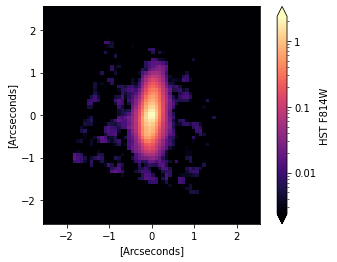

In [35]:
plot_image(lab,pixel_width=0.08)
#plot_image(pred,pixel_width=0.08)

print((np.squeeze(test_results[id])).shape)

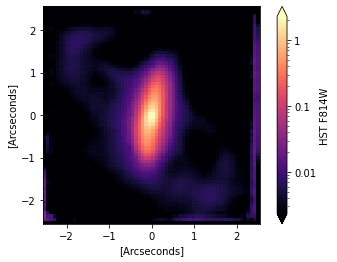

In [36]:
plot_image(pred,pixel_width=0.08)

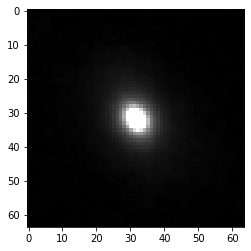

In [20]:
from PIL import Image
image_from_array = Image.fromarray(pred)
plt.imshow(lab, cmap='gray',clim=(0,1))

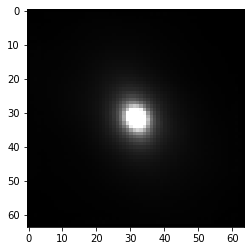

In [21]:
plt.imshow(pred, cmap='gray',clim=(0,1))

Predicted Test Sample

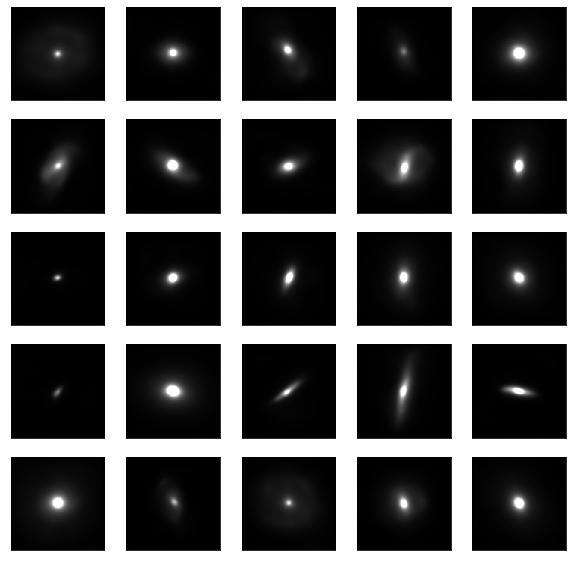

In [22]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(test_results[i])
    label = np.squeeze(x_testLabel[i])  
    plt.imshow(img, cmap='gray',clim=(0,1))

plt.show()

Test labels 

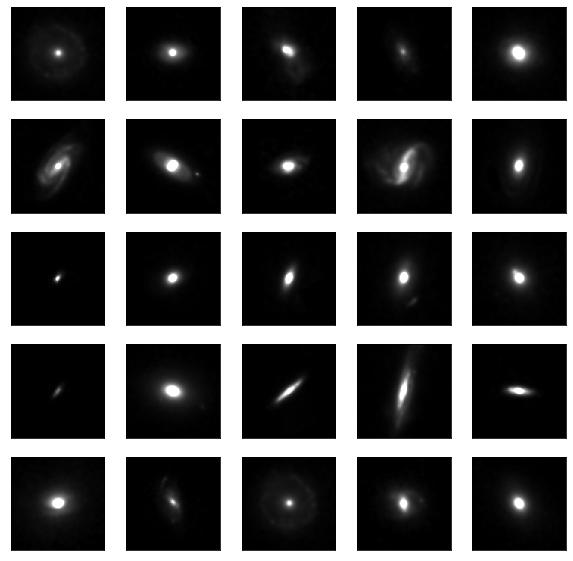

In [23]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = np.squeeze(x_testLabel[i]) 
    plt.imshow(img, cmap='gray',clim=(0,1))
plt.show()

Visualize  results
Create plots of loss on the training and validation sets.

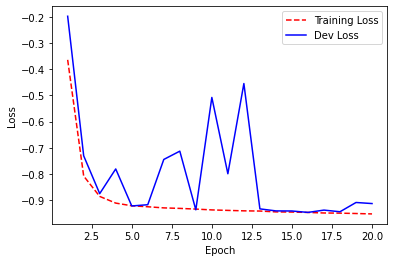

In [25]:
# Get training and test loss histories
training_loss = history6.history['loss']
dev_loss = history6.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

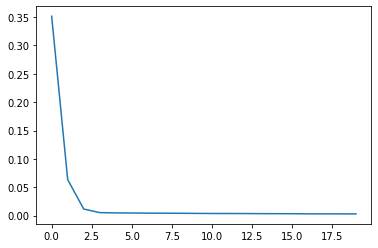

In [27]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history6.history['mse'])

pyplot.show()

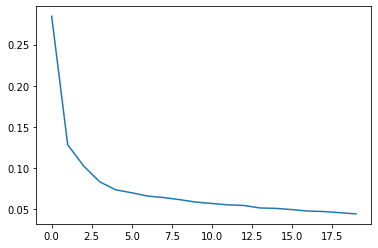

In [31]:
pyplot.plot(history6.history["ssim_loss"])
pyplot.show()

Analyze test results 